1. Se doreşte modelarea probabilităţii ca un student să promoveze un examen în funcţie de numărul de
ore de studiu pe săptămână. Datele sintetice arată astfel:

ore de studiu: 1 3 4 5 6 8

promovare (0/1): 0 0 1 1 1 1

Construiţi un model bayesian de regresie logistică care:
- să estimeze coeficienţii regresiei (interceptul şi panta), probabilitatea de mai sus şi frontiera de decizie;
- să ofere intervale de credibilitate (HDI) pentru frontiera de decizie.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 772 divergences after tuning. Increase `target_accept` or reparameterize.


Intervalul de credibilitate pentru b0: [-22.58157822  -1.43606224]
Intervalul de credibilitate pentru b1: [0.66451957 6.56924553]


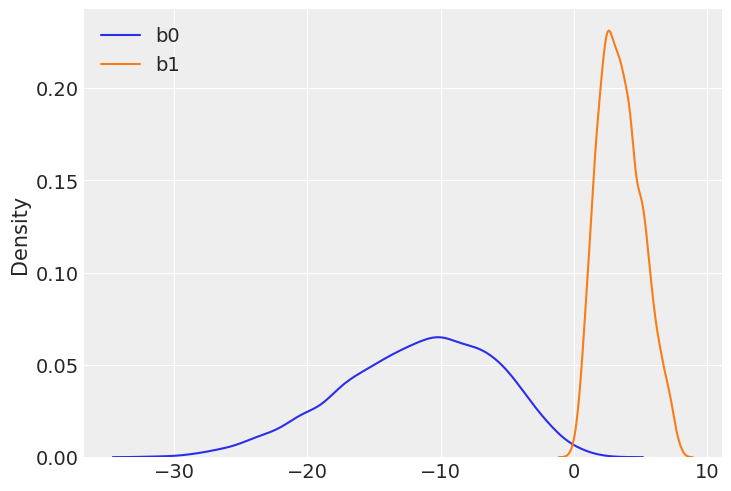

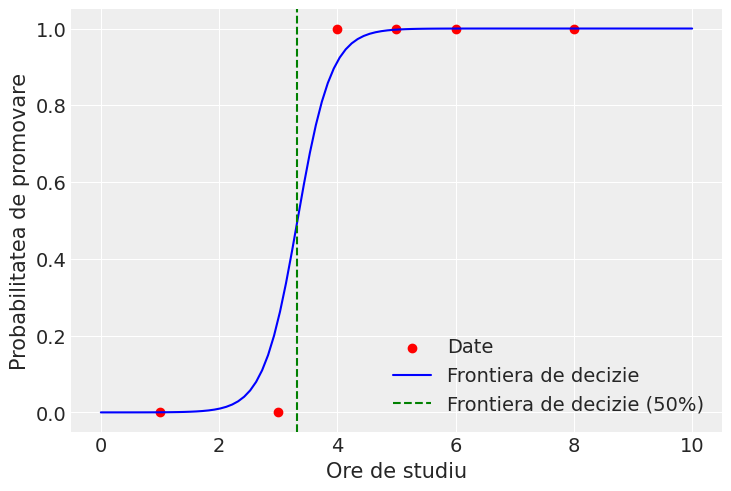

In [32]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

# Datele
study_hours = np.array([1, 3, 4, 5, 6, 8])
promote = np.array([0, 0, 1, 1, 1, 1])

# Modelul bayesian de regresie logistică
with pm.Model() as logistic_model:
    # Distribuțiile a priori pentru coeficienți
    b0 = pm.Normal('b0', mu=0, sigma=10)
    b1 = pm.Normal('b1', mu=0, sigma=10)
    
    # Probabilitatea de promovare (model logistic)
    p = pm.math.sigmoid(b0 + b1 * study_hours)
    
    # Observațiile (0 sau 1, cu probabilitatea p)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=promote)
    
    # Posterior
    trace = pm.sample(2000, return_inferencedata=False)

# Estimarea coeficientilor b0 și b1
b0_samples = trace['b0']
b1_samples = trace['b1']

# Calculul intervalelor de credibilitate (HDI) folosind pm.stats.hdi
b0_hdi = pm.stats.hdi(b0_samples)
b1_hdi = pm.stats.hdi(b1_samples)

print(f"Intervalul de credibilitate pentru b0: {b0_hdi}")
print(f"Intervalul de credibilitate pentru b1: {b1_hdi}")

# Graficul distribuitiilor coeficientilor
sns.kdeplot(b0_samples, label="b0")
sns.kdeplot(b1_samples, label="b1")
plt.legend()
plt.show()

# Calcularea frontierei de decizie
x_vals = np.linspace(0, 10, 100)
y_vals = np.mean(b0_samples) + np.mean(b1_samples) * x_vals
decision_boundary = -np.mean(b0_samples) / np.mean(b1_samples)

# Plotarea frontierei de decizie și a datelor
plt.scatter(study_hours, promote, color='red', label="Date")
plt.plot(x_vals, 1 / (1 + np.exp(-(y_vals))), label="Frontiera de decizie", color='blue')
plt.axvline(x=decision_boundary, color='green', linestyle='--', label="Frontiera de decizie (50%)")
plt.xlabel('Ore de studiu')
plt.ylabel('Probabilitatea de promovare')
plt.legend()
plt.show()


2. Ce factori determină admiterea la facultate în Statele Unite? În fişierul Admission.csv au fost strânse datele a 400 de cazuri de admitere la o facultate. “Admission” este un răspuns binar, cu 1 sau 0 indicând “admis”,
respectiv “respins”. Sunt de asemenea disponibile scorul la testul GRE şi rezultatul mediu din liceu, GPA
(undergraduate grade point average). Fie pi probabilitatea ca studentul cu nr. i să fie admis.
Considerăm modelul logistic pi = logistic(β0 + β1xi1 + β2xi2),

unde xi1 şi xi2 sunt scorul GRE, respectiv GPA pentru studentul i.
- Folosind distribuţii a priori slab informative asupra parametrilor β0, β1 şi β2, folosiţi PyMC pentru a
simula un eşantion suficient de mare (construi modelul) din distribuţia a posteriori. (0.5p)
- Care este, în medie, graniţa de decizie pentru acest model? Reprezentaţi de asemenea grafic o zonă în
jurul acestei grafic care să reprezinte un interval 94% HDI. (0.5p)
- Să presupunem că un student are un scor GRE de 550 şi un GPA de 3.5. Construiţi un interval de 90%
HDI pentru probabilitatea ca acest student să fie admis. (0.5p)
- Dar dacă studentul are un scor GRE de 500 şi un GPA de 3.2? (refaceţi exerciţiul anterior cu aceste date)
Cum justificaţi diferenţa? (0.5p)

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

#a
# 1. Încărcăm datele
data = pd.read_csv("Admission.csv")

Y = data['Admission'].values
GRE = data['GRE'].values
GPA = data['GPA'].values

# 2. Normalizare (standardizare) a predictorilor
GRE_mean, GRE_std = GRE.mean(), GRE.std()
GPA_mean, GPA_std = GPA.mean(), GPA.std()

GRE_std_data = (GRE - GRE_mean) / GRE_std
GPA_std_data = (GPA - GPA_mean) / GPA_std

# 3. Construim modelul Bayesian cu priors slab informative
with pm.Model() as model:
    # Priori slab informative pentru parametri
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)

    # Logit-ul probabilității
    logits = beta0 + beta1 * GRE_std_data + beta2 * GPA_std_data
    p = pm.math.sigmoid(logits)

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=Y)

    # 4. Sampling - creștem target_accept pentru a reduce divergențele
    trace = pm.sample(3000, tune=2000, target_accept=0.95, return_inferencedata=True)

# Rezumat a posteriori
print(az.summary(trace, var_names=["beta0", "beta1", "beta2"]))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 19 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0 -0.817  0.113  -1.032   -0.609      0.001    0.001    9931.0    8407.0   
beta1  0.315  0.121   0.089    0.544      0.001    0.001    9704.0    8830.0   
beta2  0.289  0.121   0.058    0.508      0.001    0.001    8858.0    8004.0   

       r_hat  
beta0    1.0  
beta1    1.0  
beta2    1.0  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 1 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


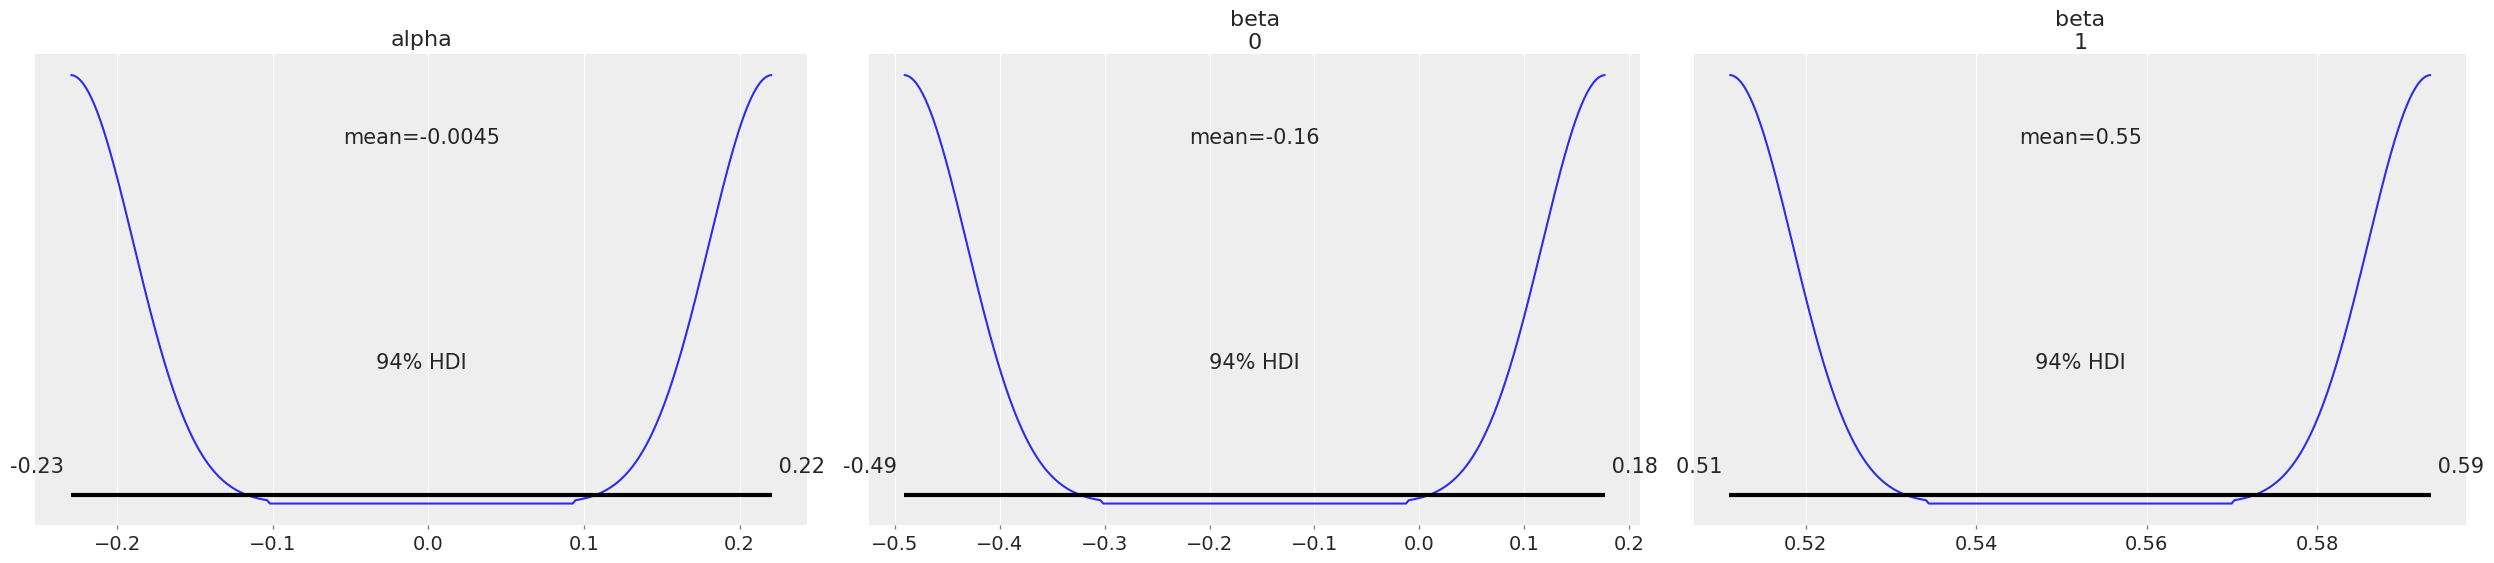

In [ ]:
#b
# Presupunem că aveți deja datele și modelul rulat:
# Y: Admission (0/1)
# GRE, GPA: datele originale
# trace: rezultatul PyMC (inferencedata) cu parametrii beta0, beta1, beta2

# Presupunem că ați salvat în prealabil mediile și deviatia standard pentru normalizare:
# GRE_mean, GRE_std, GPA_mean, GPA_std

# Eșantioane a posteriori
beta0_s = trace.posterior['beta0'].values.flatten()
beta1_s = trace.posterior['beta1'].values.flatten()
beta2_s = trace.posterior['beta2'].values.flatten()

# Definim un interval pe axa GRE în scara originală
gre_range = np.linspace(GRE.min(), GRE.max(), 100)

# Convertim aceste valori în scara standardizată, pentru a aplica formula frontierei
gre_range_std = (gre_range - GRE_mean) / GRE_std

# Pentru fiecare valoare GRE, calculăm GPA_std la p=0.5:
# 0 = beta0 + beta1*GRE_std + beta2*GPA_std
# => GPA_std = -(beta0 + beta1*GRE_std)/beta2
all_boundaries_std = []
for gre_val_std in gre_range_std:
    gpa_vals_std = -(beta0_s + beta1_s * gre_val_std) / beta2_s
    all_boundaries_std.append(gpa_vals_std)

all_boundaries_std = np.vstack(all_boundaries_std)  # (100, nr_samples)

# Mediană și HDI pe scala standardizată
median_line_std = np.median(all_boundaries_std, axis=1)

hdi_lower_std = []
hdi_upper_std = []
for row in all_boundaries_std:
    interval = az.hdi(row, hdi_prob=0.94)
    hdi_lower_std.append(interval[0])
    hdi_upper_std.append(interval[1])

hdi_lower_std = np.array(hdi_lower_std)
hdi_upper_std = np.array(hdi_upper_std)

# Denormalizare înapoi la scara originală a GPA:
median_line = median_line_std * GPA_std + GPA_mean
hdi_lower = hdi_lower_std * GPA_std + GPA_mean
hdi_upper = hdi_upper_std * GPA_std + GPA_mean

# Acum putem afișa graficul pe scara originală
plt.figure(figsize=(8,5))
plt.plot(gre_range, median_line, color='red', label='Median decision boundary')
plt.fill_between(gre_range, hdi_lower, hdi_upper, color='red', alpha=0.3, label='94% HDI')

# Datele originale
plt.scatter(GRE, GPA, c=Y, cmap='bwr', alpha=0.6, label='Data (color: admission)')

plt.xlabel("GRE")
plt.ylabel("GPA")
plt.title("Decision Boundary with 94% HDI (original scale)")
plt.legend()
plt.show()




Interval HDI de 90% pentru probabilitatea de admitere pentru un student cu GRE=550 și GPA=3.5: [0.25877416 0.34781447]


C:\Users\IdeaPad\AppData\Local\Temp\ipykernel_6264\1316529530.py:49: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(GRE_grid, GPA_grid, hdi_lower_grid, levels=[0.5], colors='red', linestyles='--', label="HDI lower bound (5%)")
C:\Users\IdeaPad\AppData\Local\Temp\ipykernel_6264\1316529530.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(GRE_grid, GPA_grid, hdi_upper_grid, levels=[0.5], colors='blue', linestyles='--', label="HDI upper bound (95%)")


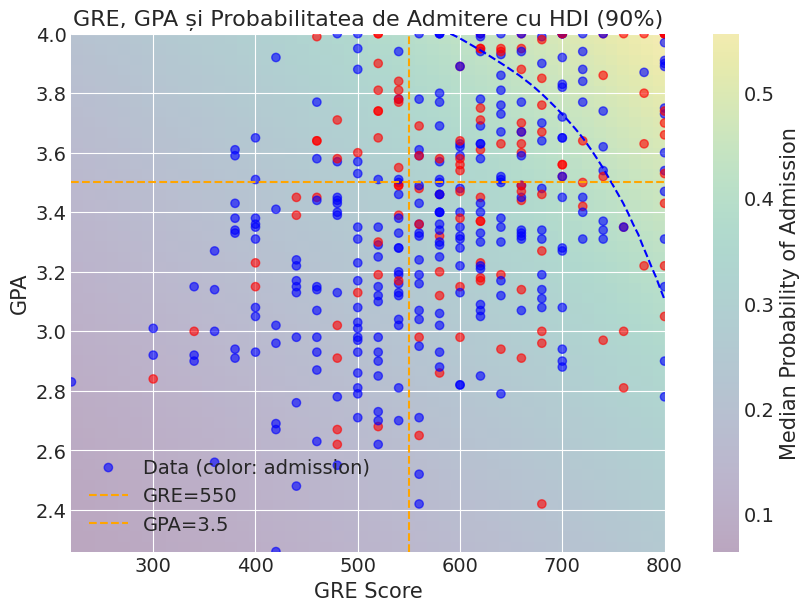

In [33]:
#c
# Datele pentru studentul cu GRE=550 și GPA=3.5
GRE_value_1 = 550
GPA_value_1 = 3.5

# Transformăm aceste valori la scara standardizată
GRE_value_std_1 = (GRE_value_1 - GRE_mean) / GRE_std
GPA_value_std_1 = (GPA_value_1 - GPA_mean) / GPA_std

# Calculăm logit-ul pentru acest student
logit_student_1 = beta0_s + beta1_s * GRE_value_std_1 + beta2_s * GPA_value_std_1

# Calculăm probabilitățile de admitere (sigmoid) pentru fiecare eșantion
p_student_1 = 1 / (1 + np.exp(-logit_student_1))

# Calculăm intervalul HDI de 90% pentru probabilitatea de admitere
hdi_student_90_1 = az.hdi(p_student_1, hdi_prob=0.90)
print(f"Interval HDI de 90% pentru probabilitatea de admitere pentru un student cu GRE={GRE_value_1} și GPA={GPA_value_1}: {hdi_student_90_1}")

# Creăm o rețea de puncte pentru a calcula probabilitatea de admitere
GRE_range = np.linspace(GRE.min(), GRE.max(), 50)  # 50 de puncte între min și max GRE
GPA_range = np.linspace(GPA.min(), GPA.max(), 50)  # 50 de puncte între min și max GPA

# Creăm o rețea de puncte pentru a calcula probabilitatea de admitere
GRE_grid, GPA_grid = np.meshgrid(GRE_range, GPA_range)
GRE_grid_std = (GRE_grid - GRE_mean) / GRE_std
GPA_grid_std = (GPA_grid - GPA_mean) / GPA_std

# Calculăm logit(p) pentru fiecare punct din rețea
logit_p_grid = beta0_s[:, None, None] + beta1_s[:, None, None] * GRE_grid_std + beta2_s[:, None, None] * GPA_grid_std

# Aplicăm sigmoid pentru a obține probabilitățile
p_grid = 1 / (1 + np.exp(-logit_p_grid))

# Calculăm intervalul HDI pentru fiecare punct din rețea
hdi_lower_grid = np.percentile(p_grid, 5, axis=0)
hdi_upper_grid = np.percentile(p_grid, 95, axis=0)

# Calculăm probabilitatea medie pentru fiecare combinație de GRE și GPA
median_p_grid = np.median(p_grid, axis=0)

# Vizualizarea graficului 2D
plt.figure(figsize=(8, 6))

# Scatter plot pentru datele originale, colorate după probabilitatea de admitere
scatter = plt.scatter(GRE, GPA, c=Y, cmap='bwr', alpha=0.6, label='Data (color: admission)')

# Contur pentru intervalul HDI al probabilității
plt.contour(GRE_grid, GPA_grid, hdi_lower_grid, levels=[0.5], colors='red', linestyles='--', label="HDI lower bound (5%)")
plt.contour(GRE_grid, GPA_grid, hdi_upper_grid, levels=[0.5], colors='blue', linestyles='--', label="HDI upper bound (95%)")

# Colormap pentru probabilitatea de admitere
plt.imshow(median_p_grid, extent=[GRE.min(), GRE.max(), GPA.min(), GPA.max()], origin='lower', aspect='auto', alpha=0.3, cmap='viridis')
plt.colorbar(label='Median Probability of Admission')

# Marcarea intervalului HDI de 90% pentru studentul cu GRE=550 și GPA=3.5
plt.axvline(x=GRE_value_1, color='orange', linestyle='--', label=f'GRE={GRE_value_1}')
plt.axhline(y=GPA_value_1, color='orange', linestyle='--', label=f'GPA={GPA_value_1}')

# Etichete și titlu
plt.xlabel('GRE Score')
plt.ylabel('GPA')
plt.title('GRE, GPA și Probabilitatea de Admitere cu HDI (90%)')
plt.legend()

plt.show()

Interval HDI de 90% pentru probabilitatea de admitere pentru un student cu GRE=500 și GPA=3.2: [0.18752891 0.28116303]


C:\Users\IdeaPad\AppData\Local\Temp\ipykernel_6264\1652270957.py:49: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(GRE_grid, GPA_grid, hdi_lower_grid, levels=[0.5], colors='red', linestyles='--', label="HDI lower bound (5%)")
C:\Users\IdeaPad\AppData\Local\Temp\ipykernel_6264\1652270957.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(GRE_grid, GPA_grid, hdi_upper_grid, levels=[0.5], colors='blue', linestyles='--', label="HDI upper bound (95%)")


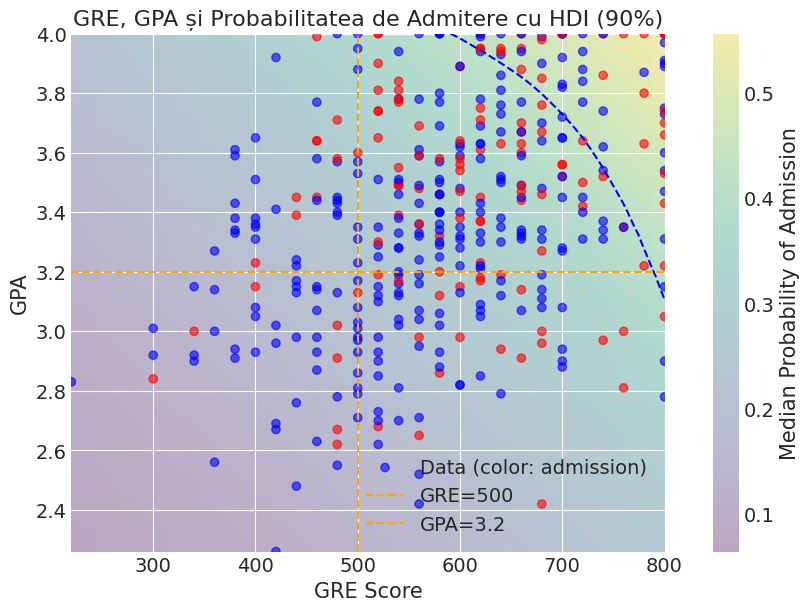

In [30]:
#d
# Datele pentru studentul cu GRE=500 și GPA=3.2
GRE_value_2 = 500
GPA_value_2 = 3.2

# Transformăm aceste valori la scara standardizată
GRE_value_std_2 = (GRE_value_2 - GRE_mean) / GRE_std
GPA_value_std_2 = (GPA_value_2 - GPA_mean) / GPA_std

# Calculăm logit-ul pentru acest student
logit_student_2 = beta0_s + beta1_s * GRE_value_std_2 + beta2_s * GPA_value_std_2

# Calculăm probabilitățile de admitere (sigmoid) pentru fiecare eșantion
p_student_2 = 1 / (1 + np.exp(-logit_student_2))

# Calculăm intervalul HDI de 90% pentru probabilitatea de admitere
hdi_student_90_2 = az.hdi(p_student_2, hdi_prob=0.90)
print(f"Interval HDI de 90% pentru probabilitatea de admitere pentru un student cu GRE={GRE_value_2} și GPA={GPA_value_2}: {hdi_student_90_2}")

# Creăm o rețea de puncte pentru a calcula probabilitatea de admitere
GRE_range = np.linspace(GRE.min(), GRE.max(), 50)  # 50 de puncte între min și max GRE
GPA_range = np.linspace(GPA.min(), GPA.max(), 50)  # 50 de puncte între min și max GPA

# Creăm o rețea de puncte pentru a calcula probabilitatea de admitere
GRE_grid, GPA_grid = np.meshgrid(GRE_range, GPA_range)
GRE_grid_std = (GRE_grid - GRE_mean) / GRE_std
GPA_grid_std = (GPA_grid - GPA_mean) / GPA_std

# Calculăm logit(p) pentru fiecare punct din rețea
logit_p_grid = beta0_s[:, None, None] + beta1_s[:, None, None] * GRE_grid_std + beta2_s[:, None, None] * GPA_grid_std

# Aplicăm sigmoid pentru a obține probabilitățile
p_grid = 1 / (1 + np.exp(-logit_p_grid))

# Calculăm intervalul HDI pentru fiecare punct din rețea
hdi_lower_grid = np.percentile(p_grid, 5, axis=0)
hdi_upper_grid = np.percentile(p_grid, 95, axis=0)

# Calculăm probabilitatea medie pentru fiecare combinație de GRE și GPA
median_p_grid = np.median(p_grid, axis=0)

# Vizualizarea graficului 2D
plt.figure(figsize=(8, 6))

# Scatter plot pentru datele originale, colorate după probabilitatea de admitere
scatter = plt.scatter(GRE, GPA, c=Y, cmap='bwr', alpha=0.6, label='Data (color: admission)')

# Contur pentru intervalul HDI al probabilității
plt.contour(GRE_grid, GPA_grid, hdi_lower_grid, levels=[0.5], colors='red', linestyles='--', label="HDI lower bound (5%)")
plt.contour(GRE_grid, GPA_grid, hdi_upper_grid, levels=[0.5], colors='blue', linestyles='--', label="HDI upper bound (95%)")

# Colormap pentru probabilitatea de admitere
plt.imshow(median_p_grid, extent=[GRE.min(), GRE.max(), GPA.min(), GPA.max()], origin='lower', aspect='auto', alpha=0.3, cmap='viridis')
plt.colorbar(label='Median Probability of Admission')

# Marcarea intervalului HDI de 90% pentru studentul cu GRE=500 și GPA=3.2
plt.axvline(x=GRE_value_2, color='orange', linestyle='--', label=f'GRE={GRE_value_2}')
plt.axhline(y=GPA_value_2, color='orange', linestyle='--', label=f'GPA={GPA_value_2}')

# Etichete și titlu
plt.xlabel('GRE Score')
plt.ylabel('GPA')
plt.title('GRE, GPA și Probabilitatea de Admitere cu HDI (90%)')
plt.legend()

plt.show()

Diferența în probabilitatea de admitere între cei doi studenți se datorează diferențelor dintre scorurile lor GRE și GPA.

Studentul 1 (GRE 550, GPA 3.5) are scoruri mai mari la ambele variabile, ceea ce indică o pregătire academică mai bună și, prin urmare, o probabilitate mai mare de admitere.
Studentul 2 (GRE 500, GPA 3.2), cu scoruri mai mici, are o probabilitate de admitere mai scăzută, deoarece performanțele academice sunt mai slabe.
Modelul logistic reflectă aceste diferențe prin coeficientul pentru fiecare variabilă, iar un GRE și GPA mai mari duc la o probabilitate mai mare de admitere.

Ex de student care va fi admis: GRE 600, GPA 3.8